In [ ]:
!pip install catboost
!pip install pdpbox
!pip install miceforest
!pip install fancyimpute

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from glob import glob
import os, random, time, gc, warnings

from tqdm import tqdm_notebook

import lightgbm as lgbm
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

from sklearn.cluster import KMeans

from datetime import datetime

from math import sqrt

import folium
from folium import Marker, Icon, CircleMarker
from sklearn.model_selection import train_test_split

from pdpbox import pdp, info_plots

warnings.filterwarnings('ignore')


%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [3]:
import os, sys
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
default_dir = "/content/gdrive/My Drive"
df_train = pd.read_csv(os.path.join(default_dir,"train.csv")) # 학습용 데이터
df_test = pd.read_csv(os.path.join(default_dir,"submission.csv")) # 테스트 데이터(제출파일의 데이터)

In [5]:
df_train.head()

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,idit_strategic_ver,customer_job,lead_desc_length,inquiry_type,product_category,product_subcategory,product_modelname,customer_country.1,customer_position,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.0,/Quezon City/Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,NaN,purchasing,62,Quotation or purchase consultation,multi-split,NaN,NaN,/Quezon City/Philippines,entry level,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True
1,1.0,/PH-00/Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,NaN,media and communication,96,Quotation or purchase consultation,multi-split,NaN,NaN,/PH-00/Philippines,ceo/founder,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True
2,1.0,/Kolkata /India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,NaN,engineering,56,Product Information,single-split,NaN,NaN,/Kolkata /India,partner,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True
3,1.0,/Bhubaneswar/India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,NaN,entrepreneurship,44,Quotation or purchase consultation,vrf,NaN,NaN,/Bhubaneswar/India,ceo/founder,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True
4,1.0,/Hyderabad/India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,NaN,consulting,97,Quotation or purchase consultation,multi-split,NaN,NaN,/Hyderabad/India,partner,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  float64
 1   customer_country         58317 non-null  object 
 2   business_unit            59299 non-null  object 
 3   com_reg_ver_win_rate     14568 non-null  float64
 4   customer_idx             59299 non-null  int64  
 5   customer_type            15338 non-null  object 
 6   enterprise               59299 non-null  object 
 7   historical_existing_cnt  13756 non-null  float64
 8   id_strategic_ver         3444 non-null   float64
 9   it_strategic_ver         1121 non-null   float64
 10  idit_strategic_ver       4565 non-null   float64
 11  customer_job             40566 non-null  object 
 12  lead_desc_length         59299 non-null  int64  
 13  inquiry_type             58358 non-null  object 
 14  product_category      

In [7]:
def get_crosstab(df, feature):
  crosstab = pd.crosstab(df[feature],df['is_converted'],normalize='index')*100
  crosstab = crosstab.reset_index()
  return crosstab

In [8]:
def write_percent(ax, total_size):
    for patch in ax.patches:
        height = patch.get_height()     # 도형 높이(데이터 개수)
        width = patch.get_width()       # 도형 너비
        left_coord = patch.get_x()      # 도형 왼쪽 테두리의 x축 위치
        percent = height/total_size*100 # 타깃값 비율

        # (x, y) 좌표에 텍스트 입력
        ax.text(x=left_coord + width/2.0,    # x축 위치
                y=height + total_size*0.001, # y축 위치
                s=f'{percent:1.1f}%',        # 입력 텍스트
                ha='center')

In [9]:
import matplotlib.gridspec as gridspec

def plot_pointplot(ax, feature, crosstab):
  ax2 = ax.twinx()
  ax2 = sns.pointplot(x=feature, y = 1, data = crosstab, order=crosstab[feature].values,
                      color = 'black',
                      legend=False)
  ax2.set_ylim(crosstab[1].min()-5, crosstab[1].max()*1.1)
  ax2.set_ylabel('Target 1 Ratio(%)')

def plot_cat_dist_with_true_ratio(df, features, num_rows, num_cols,
                                  size=(5,5 )):
    plt.figure(figsize=size)  # 전체 Figure 크기 설정
    grid = gridspec.GridSpec(num_rows, num_cols) # 서브플롯 배치
    plt.subplots_adjust(wspace=0.45, hspace=0.3) # 서브플롯 좌우/상하 여백 설정

    for idx, feature in enumerate(features):
        ax = plt.subplot(grid[idx])
        crosstab = get_crosstab(df, feature) # 교차분석표 생성

        # ax축에 타깃값 분포 카운트플롯 그리기
        sns.countplot(x=feature, data=df,
                      order=crosstab[feature].values,
                      color='skyblue',
                      ax=ax)

        write_percent(ax, len(df)) # 비율 표시

        plot_pointplot(ax, feature, crosstab) # 포인트플롯 그리기

        ax.set_title(f'{feature} Distribution') # 그래

In [10]:
import matplotlib as mpl

def plot_target_ratio_by_feature(df, feature, size=(5, 5)):
    plt.figure(figsize=size)
    sns.barplot(x=feature, y='is_converted', data=df, palette='Set2')


# Column별 파악

# bant_submit
- 결측 치 없음
- 피처 사용

In [11]:
df_train['bant_submit'].value_counts()

0.50    17192
1.00    17061
0.25    12852
0.75    11681
0.00      513
Name: bant_submit, dtype: int64

In [12]:
crosstab = pd.crosstab(df_train['bant_submit'],df_train['is_converted'],normalize='index')*100
display(crosstab)

is_converted,False,True
bant_submit,,
0.00,84.015595,15.984405
0.25,90.102708,9.897292
0.50,94.549791,5.450209
0.75,90.437463,9.562537
1.00,91.547975,8.452025


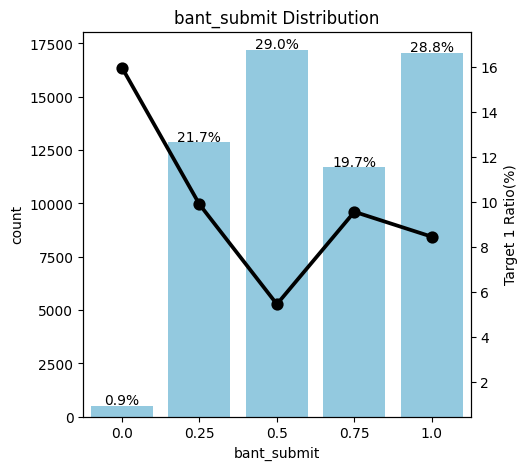

In [13]:
plot_cat_dist_with_true_ratio(df_train, ['bant_submit'], num_rows=1, num_cols=1)

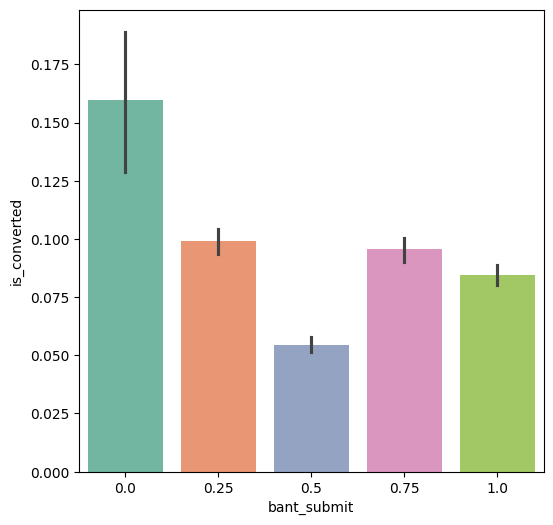

In [14]:
plot_target_ratio_by_feature(df_train, 'bant_submit', size=(6, 6))

# customer_country ( + response_corporate )
- customer_country.1과 동일하다
- customer_country.1 : 담당 자사 법인명 기반의 지역 정보(대륙)
- response_corporate : 담당 자사 법인명이 있다 -> response_corporate 기반으로 대륙 칼럼 만들어서 재범주화 해볼 수 있음
- 슬래시로 국가와 도시가 구분되어 있음 :첫 번째는 'City', 두 번째는 'Country'로 새로운 칼럼 만듬
- 결측 치 비율이 낮다(0.016560) -> 결측 치 행 삭제


In [15]:
df_train['customer_country'].value_counts()

//India                                   3037
/São Paulo/Brazil                         1344
//United States                            962
//United Kingdom                           805
//Saudi Arabia                             718
                                          ... 
/Hydrated/India                              1
/Tirurangadi, Malappuram, Kerala/India       1
/Canoinhas / SC/Brazil                       1
/Tupã/SP/Brazil                              1
/paris/France                                1
Name: customer_country, Length: 15399, dtype: int64

In [16]:
df_train['customer_country.1'].value_counts()

//India                                   3037
/São Paulo/Brazil                         1344
//United States                            962
//United Kingdom                           805
//Saudi Arabia                             718
                                          ... 
/Hydrated/India                              1
/Tirurangadi, Malappuram, Kerala/India       1
/Canoinhas / SC/Brazil                       1
/Tupã/SP/Brazil                              1
/paris/France                                1
Name: customer_country.1, Length: 15399, dtype: int64

In [17]:
crosstab1 = pd.crosstab(df_train['customer_country'],df_train['is_converted'],normalize='index')*100
display(crosstab1)

is_converted,False,True
customer_country,,
#314 G. Araneta Ave. Quezon City NCR //Philippines,0.0,100.0
#314 G. Araneta Ave. Quezon City NCR /Caloocan City/Philippines,0.0,100.0
#7/2 Jaishree Plaza Advaitha Ashram Road /Salem/,100.0,0.0
.Mpilo and Pioneer Road Maseru /Maseru/,100.0,0.0
"/\tWest Drayton , Harmondsworth/United Kingdom",100.0,0.0
...,...,...
Ấp Mỹ Tân Thị Trấn Mỹ Luông //Vietnam,100.0,0.0
Ấp Vĩnh Phú xã Vĩnh thạnh //Vietnam,100.0,0.0
Ấp chợ tập sơn trà cú trà vinh //Vietnam,100.0,0.0


In [18]:
df_train['customer_country'].unique().tolist()

['/Quezon City/Philippines',
 '/PH-00/Philippines',
 '/Kolkata /India',
 '/Bhubaneswar/India',
 '/Hyderabad/India',
 '/Abuja/Nigeria',
 '/Jeddah, KSA/Saudi Arabia',
 '/Guwahati/India',
 '/Cebu city/Philippines',
 '/hauz khas,delhi/India',
 '/hosur/India',
 '/Koduvai, Tiruppur/India',
 '/Benin City/Nigeria',
 '/Lagos/Nigeria',
 '/Riyadh/Saudi Arabia',
 '/Singapore/Singapore',
 '//Philippines',
 '/Cebu City/Philippines',
 '/Noida/India',
 '/BENGALURU/India',
 '/chennai/India',
 '/ghaziabad/India',
 '/Pune/India',
 '/KANPUR/India',
 '/RS/Brazil',
 '/Dubai/U.A.E',
 '/Johannesburh/South Africa',
 '/Posey/United States',
 '/Bauan Batangas/Philippines',
 '/Metro manila/Philippines',
 '/Taguig/Philippines',
 '/Mysore/India',
 '/Kolkata/India',
 '/Chennai/India',
 '/Bangalore/India',
 '/New Delhi/India',
 '/Kaithal /India',
 '/kozhikode/India',
 '/Badarpur/India',
 '/Gopalganj/India',
 '/Mumbai /India',
 '/MALDA/India',
 '/COIMBATORE/India',
 '/Aurangabad/India',
 '/AHMEDABAD/India',
 '/Santa C

In [19]:
# 결측치
df_train.dropna(subset=['customer_country'], inplace=True)

In [20]:
df_train['customer_country'] = df_train['customer_country'].str.upper()
df_train['City'] = df_train['customer_country'].str.split('/').str[1].str.strip()
df_train['Country'] = df_train['customer_country'].str.split('/').str[2].str.strip()

In [21]:
df_train['Country'].unique().tolist()

['PHILIPPINES',
 'INDIA',
 'NIGERIA',
 'SAUDI ARABIA',
 'SINGAPORE',
 'BRAZIL',
 'U.A.E',
 'SOUTH AFRICA',
 'UNITED STATES',
 'COLOMBIA',
 'MEXICO',
 'GHANA',
 'EGYPT',
 'DEMOCRATIC REPUBLIC OF THE CONGO',
 'ETHIOPIA',
 'AUSTRALIA',
 'KENYA',
 nan,
 'OMAN',
 'PAKISTAN',
 'UNITED KINGDOM',
 'GUATEMALA',
 'PANAMA',
 'CANADA',
 'BANGLADESH',
 'PAPUA NEW GUINEA',
 'UNITED REPUBLIC OF TANZANIA',
 'INDONESIA',
 'JAWA TENGAH',
 'QATAR',
 'AFGHANISTAN',
 'CHILE',
 'MOZAMBIQUE',
 'TURKEY',
 'TÜRKIYE',
 'EL SALVADOR',
 'TOGO',
 'IRAQ',
 'ISRAEL',
 'COLOMBO',
 'SOUTH KOREA',
 'PORTUGAL',
 'MAURITANIA',
 'URUGUAY',
 'PERU',
 'GERMANY',
 'ROMANIA',
 'NORWAY',
 'ES',
 'JAMAICA',
 '',
 'HUNGARY',
 'CONNECTICUT UNITED STATES',
 'POLAND',
 'CZECH',
 'SPAIN',
 'ARGENTINA',
 'ECUADOR',
 'SENEGAL',
 'HONG KONG',
 'MALAYSIA',
 'TOSHIMA',
 'KUWAIT',
 'IRELAND',
 'ALBANIA',
 'GURGAON, SEC-37, PACE CITY',
 'GASPAR',
 'GREECE',
 'ALGERIA',
 'NICARAGUA',
 'SLOVENIA',
 'ITALY',
 'JAPAN',
 'NETHERLANDS',
 'ISLAMA

In [22]:
df_train['City'].unique().tolist()

['QUEZON CITY',
 'PH-00',
 'KOLKATA',
 'BHUBANESWAR',
 'HYDERABAD',
 'ABUJA',
 'JEDDAH, KSA',
 'GUWAHATI',
 'CEBU CITY',
 'HAUZ KHAS,DELHI',
 'HOSUR',
 'KODUVAI, TIRUPPUR',
 'BENIN CITY',
 'LAGOS',
 'RIYADH',
 'SINGAPORE',
 '',
 'NOIDA',
 'BENGALURU',
 'CHENNAI',
 'GHAZIABAD',
 'PUNE',
 'KANPUR',
 'RS',
 'DUBAI',
 'JOHANNESBURH',
 'POSEY',
 'BAUAN BATANGAS',
 'METRO MANILA',
 'TAGUIG',
 'MYSORE',
 'BANGALORE',
 'NEW DELHI',
 'KAITHAL',
 'KOZHIKODE',
 'BADARPUR',
 'GOPALGANJ',
 'MUMBAI',
 'MALDA',
 'COIMBATORE',
 'AURANGABAD',
 'AHMEDABAD',
 'SANTA CRUZ DO SUL - RS',
 'UMM AL QUWAIN',
 'CENTURION',
 'BOGOTA',
 'MEDELLÍN',
 'BARRANCABERMEJA',
 'BUCARAMANGA',
 'MEDELLIN',
 'MÉXICO',
 'MEXICO',
 'TEMA',
 'STERLING',
 'DAMMAM',
 'NCR',
 'METRO MANILA, THIRD DISTRICT',
 'GENERAL TRIAS, CAVITE',
 'JAIPUR',
 'VIJAYAWADA',
 'PORBANDAR',
 'AJMAN',
 'EGYPT',
 'CAIRO',
 'KIGALI-RWANDA',
 'ASMARA',
 'BRASILIA-DF',
 'HEIDELBERG WEST',
 'CALI',
 'MIAMI',
 'LA TRINIDAD',
 'MUNTINLUPA CITY',
 'LABO, CA

In [23]:
pd.set_option('display.max_rows', None)

In [24]:
df_train['Country'].value_counts()

INDIA                                                        16742
BRAZIL                                                        7978
UNITED STATES                                                 3709
PHILIPPINES                                                   2494
MEXICO                                                        2287
                                                              2002
COLOMBIA                                                      1966
U.A.E                                                         1587
SAUDI ARABIA                                                  1441
UNITED KINGDOM                                                1409
CHILE                                                         1198
PERU                                                          1110
ITALY                                                         1092
GERMANY                                                        881
POLAND                                                        

In [25]:
df_train['City'].value_counts()

                                                                             14619
SÃO PAULO                                                                     1746
MUMBAI                                                                         739
HYDERABAD                                                                      673
LIMA                                                                           660
BANGALORE                                                                      653
SANTIAGO                                                                       637
DUBAI                                                                          562
PUNE                                                                           559
DELHI                                                                          489
CHENNAI                                                                        399
BOGOTÁ                                                                         392
RIO 

In [26]:
crosstab2 = pd.crosstab(df_train['Country'],df_train['is_converted'],normalize='index')*100
display(crosstab2)

is_converted,False,True
Country,,
,95.804196,4.195804
", MO 64802",100.000000,0.000000
1,100.000000,0.000000
10122 TORINO,100.000000,0.000000
106-15 SUTPHIN BLVD JAMAICA,100.000000,0.000000
14 TÁM DANH P4.Q8.TPHCM,100.000000,0.000000
2021 4:06:18 AM,100.000000,0.000000
2021 4:18:56 AM,0.000000,100.000000
2021 4:27:33 AM,100.000000,0.000000


In [27]:
df_train['response_corporate'].value_counts()

LGEIL    16882
LGESP     8753
LGEUS     5955
LGEMS     2762
LGEPH     2642
LGEGF     2104
LGECB     2079
LGEUK     1528
LGESJ     1459
LGECL     1334
LGEPS     1244
LGEIS     1144
LGEPR     1128
LGEDG      954
LGEPL      848
LGEEG      700
LGEVH      606
LGEES      582
LGETK      537
LGEAR      483
LGEKR      427
LGEHK      381
LGEAP      365
LGESL      345
LGEMK      331
LGEFS      289
LGEAF      284
LGEIN      274
LGELF      273
LGESA      263
LGECI      261
LGETH      184
LGEEF      157
LGEPT      111
LGEML      107
LGEBN       98
LGEYK       78
LGECH       65
LGEHS       50
LGETT       47
LGEJP       40
LGEAS       33
LGESW       30
LGEMC       30
LGERO       29
LGEEB       13
LGEAG        8
LGERA        8
LGECZ        7
LGELA        2
LGEUR        1
LGEIR        1
LGEBT        1
Name: response_corporate, dtype: int64

In [28]:
continent_mapping = {
    'North America': ['LGEMX', 'LGERS', 'LGEAZ', 'LGEMM', 'LGESP', 'LGEAI', 'LGECI', 'LGEUS', 'LGEMU', 'LGEMS', 'LGEAR', 'LGEPS', 'LGECB', 'LGECL', 'LGEPR'],
    'Europe': ['LGEWA', 'LGEMA', 'LGEWR', 'LGEUK', 'LGEFS', 'LGEES', 'LGEEH', 'LGEJE', 'LGEDG', 'LGEIS', 'LGEMK', 'LGEPL', 'LGESW', 'LGEHS', 'LGEAG', 'LGERO', 'LGECZ', 'LGEPT', 'LGEBN', 'LGESC', 'LGELS', 'LGENO'],
    'Central America': ['LGEEG', 'LGEAT', 'LGESR', 'LGETK', 'LGESA', 'LGEMC', 'LGEGF', 'LGEME', 'LGEOT', 'LGEEC', 'LGENI', 'LGEAF', 'LGELF'],
    'Asia': ['LGEIL', 'LGETH', 'LGEVN', 'LGEIN', 'LGECH', 'LGEHK', 'LGESL', 'LGEML', 'LGEJP', 'LGETT', 'LGEPH'],
    'China': ['LGETR', 'LGEHZ', 'LGEND', 'LGEPN', 'LGEQH', 'LGESH', 'LGESY', 'LGETA', 'LGEYT', 'LGEKS', 'LGENP', 'LGEHN', 'LGEQD'],
    'CSI Other': ['LGEAK', 'LGERA', 'LGEAP', 'LGERI', 'LGERM', 'LGEUR', 'LGELV']
}

df_train['Continent'] = ''
for continent, values in continent_mapping.items():
    df_train.loc[df_train['response_corporate'].isin(values), 'Continent'] = continent


In [29]:
df_train.head(30)

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,idit_strategic_ver,customer_job,lead_desc_length,inquiry_type,product_category,product_subcategory,product_modelname,customer_country.1,customer_position,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted,City,Country,Continent
0,1.00,/QUEZON CITY/PHILIPPINES,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,NaN,purchasing,62,Quotation or purchase consultation,multi-split,NaN,NaN,/Quezon City/Philippines,entry level,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True,QUEZON CITY,PHILIPPINES,Asia
1,1.00,/PH-00/PHILIPPINES,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,NaN,media and communication,96,Quotation or purchase consultation,multi-split,NaN,NaN,/PH-00/Philippines,ceo/founder,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True,PH-00,PHILIPPINES,Asia
2,1.00,/KOLKATA /INDIA,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,NaN,engineering,56,Product Information,single-split,NaN,NaN,/Kolkata /India,partner,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True,KOLKATA,INDIA,Asia
3,1.00,/BHUBANESWAR/INDIA,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,NaN,entrepreneurship,44,Quotation or purchase consultation,vrf,NaN,NaN,/Bhubaneswar/India,ceo/founder,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True,BHUBANESWAR,INDIA,Asia
4,1.00,/HYDERABAD/INDIA,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,NaN,consulting,97,Quotation or purchase consultation,multi-split,NaN,NaN,/Hyderabad/India,partner,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True,HYDERABAD,INDIA,Asia
5,1.00,/ABUJA/NIGERIA,AS,0.040816,16328,End-Customer,SMB,NaN,NaN,NaN,NaN,program and project management,1114,Quotation or purchase consultation,chiller,NaN,NaN,/Abuja/Nigeria,manager,LGEAF,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,5,True,ABUJA,NIGERIA,Central America
6,0.75,"/JEDDAH, KSA/SAUDI ARABIA",AS,0.040816,20664,End-Customer,SMB,NaN,NaN,NaN,NaN,engineering,420,Quotation or purchase consultation,single-split,NaN,NaN,"/Jeddah, KSA/Saudi Arabia",manager,LGESJ,NaN,1,0,0.003079,0.026846,corporate / office,Engineering,6,True,"JEDDAH, KSA",SAUDI ARABIA,
7,1.00,/GUWAHATI/INDIA,AS,0.088889,17983,End-Customer,SMB,NaN,NaN,NaN,NaN,sales,205,Quotation or purchase consultation,vrf,NaN,NaN,/Guwahati/India,partner,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Manufacturing,7,True,GUWAHATI,INDIA,Asia
8,0.75,/CEBU CITY/PHILIPPINES,AS,0.066667,30867,Specifier/ Influencer,Enterprise,3.0,NaN,NaN,NaN,other,103,Quotation or purchase consultation,multi-split,NaN,NaN,/Cebu city/Philippines,vice president,LGEPH,less than 3 months,0,0,0.003079,0.026846,corporate / office,Construction,8,True,CEBU CITY,PHILIPPINES,Asia
9,0.75,"/HAUZ KHAS,DELHI/INDIA",AS,0.088889,6084,End-Customer,SMB,NaN,NaN,NaN,NaN,other,252,Quotation or purchase consultation,vrf,NaN,NaN,"/hauz khas,delhi/India",manager,LGEIL,3 months ~ 6 months,1,0,0.003079,0.026846,corporate / office,NaN,9,True,"HAUZ KHAS,DELHI",INDIA,Asia


In [30]:
crosstab3 = pd.crosstab(df_train['Continent'],df_train['is_converted'],normalize='index')*100
display(crosstab3)

is_converted,False,True
Continent,,
,94.958588,5.041412
Asia,91.725092,8.274908
CSI Other,87.433155,12.566845
Central America,89.024099,10.975901
Europe,95.889499,4.110501
North America,91.307971,8.692029


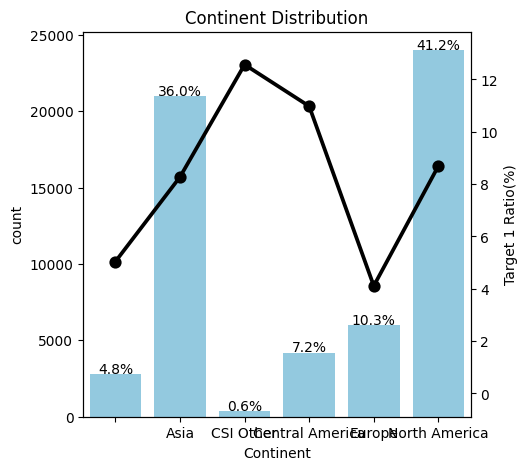

In [31]:
plot_cat_dist_with_true_ratio(df_train, ['Continent'], num_rows=1, num_cols=1)

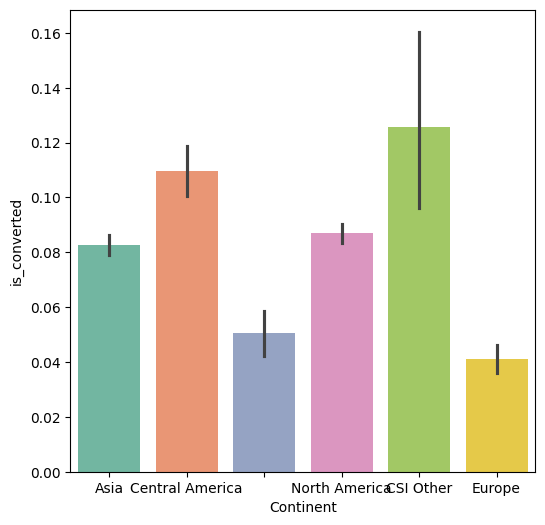

In [32]:
plot_target_ratio_by_feature(df_train, 'Continent', size=(6, 6))